# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
from scipy.stats import sem  

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import seaborn as sns


def load_data():
    #load data
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
    # convert date from object to date
    df['Date'] =pd.to_datetime(df.Date)
    # get month and date  in order to caculate min and max temp per day
    df['month&date'] = df['Date'].dt.strftime('%m/%d')
    #create index by date
    df = df.reset_index(drop=True)
    df = df.set_index(['Date'])

    # remove leak dates, i.e. feb 29 ( date need set as index in order to use this ) 
    df = df[~((df.index.month == 2) & (df.index.day == 29))]

    #  sort by id and index
    df.sort_index(level=['Date'])
    
    # Get temperature in Deg C- this has memory issue if /10.0
    df['Temperature'] = df['Data_Value']*0.1
    return df 
df=load_data()

In [4]:
# check column types 
df.dtypes

ID              object
Element         object
Data_Value       int64
month&date      object
Temperature    float64
dtype: object

In [5]:
df.head()

,ID,Element,Data_Value,month&date,Temperature
Date,,,,,
2014-11-12,USW00094889,TMAX,22,11/12,2.2
2009-04-29,USC00208972,TMIN,56,04/29,5.6
2008-05-26,USC00200032,TMAX,278,05/26,27.8
2005-11-11,USC00205563,TMAX,139,11/11,13.9
2014-02-27,USC00200230,TMAX,-106,02/27,-10.6


In [6]:
#create dateset 2004-2014 and calculate the min and max .
df0514=df[(df.index.year>=2005)&(df.index.year<=2014)].groupby('month&date')['Temperature'].agg(['max', 'min']).reset_index()

In [7]:
# convert  month&date to float in order to chart 
import matplotlib.dates as dates

df0514['md'] = df0514['month&date'].apply(lambda x: dates.datestr2num(x))
df0514.dtypes
df0514.head()

,month&date,max,min,md
0,01/01,15.6,-16.0,736695.0
1,01/02,13.9,-26.7,736696.0
2,01/03,13.3,-26.7,736697.0
3,01/04,10.6,-26.1,736698.0
4,01/05,12.8,-15.0,736699.0


In [8]:
#create dateset 2015 and calculate the min and max .

df2015 = df[df.index.year==2015].groupby('month&date')['Temperature'].agg(['max', 'min']).rename(columns={'max': 'max2015', 'min': 'min2015'}).reset_index()

df2015.head()



,month&date,max2015,min2015
0,01/01,1.1,-13.3
1,01/02,3.9,-12.2
2,01/03,3.9,-6.7
3,01/04,4.4,-8.8
4,01/05,2.8,-15.5


In [10]:
# merge data together 
df0515 = pd.merge(df0514, df2015, how='outer', left_on='month&date', right_on='month&date')
# flag the points that  2015 min < 2005-2014 min , 2015 max > 2004-2014 max temp
df0515['ismin'] = df0515['min2015'] < df0515['min']
df0515['ismax'] = df0515['max2015'] > df0515['max']
df0515=df0515[(df0515.ismin == True ) | (df0515.ismax == True)]

df0515.head()
    

,month&date,max,min,md,max2015,min2015,ismin,ismax
4,01/05,12.8,-15.0,736699.0,2.8,-15.5,True,False
10,01/11,15.6,-18.3,736705.0,0.6,-20.0,True,False
33,02/03,8.9,-23.2,736728.0,-2.1,-23.8,True,False
39,02/09,7.8,-21.0,736734.0,8.3,-11.6,False,True
44,02/14,10.6,-21.7,736739.0,-2.7,-23.9,True,False


In [11]:
# create plot 

<IPython.core.display.Javascript object>


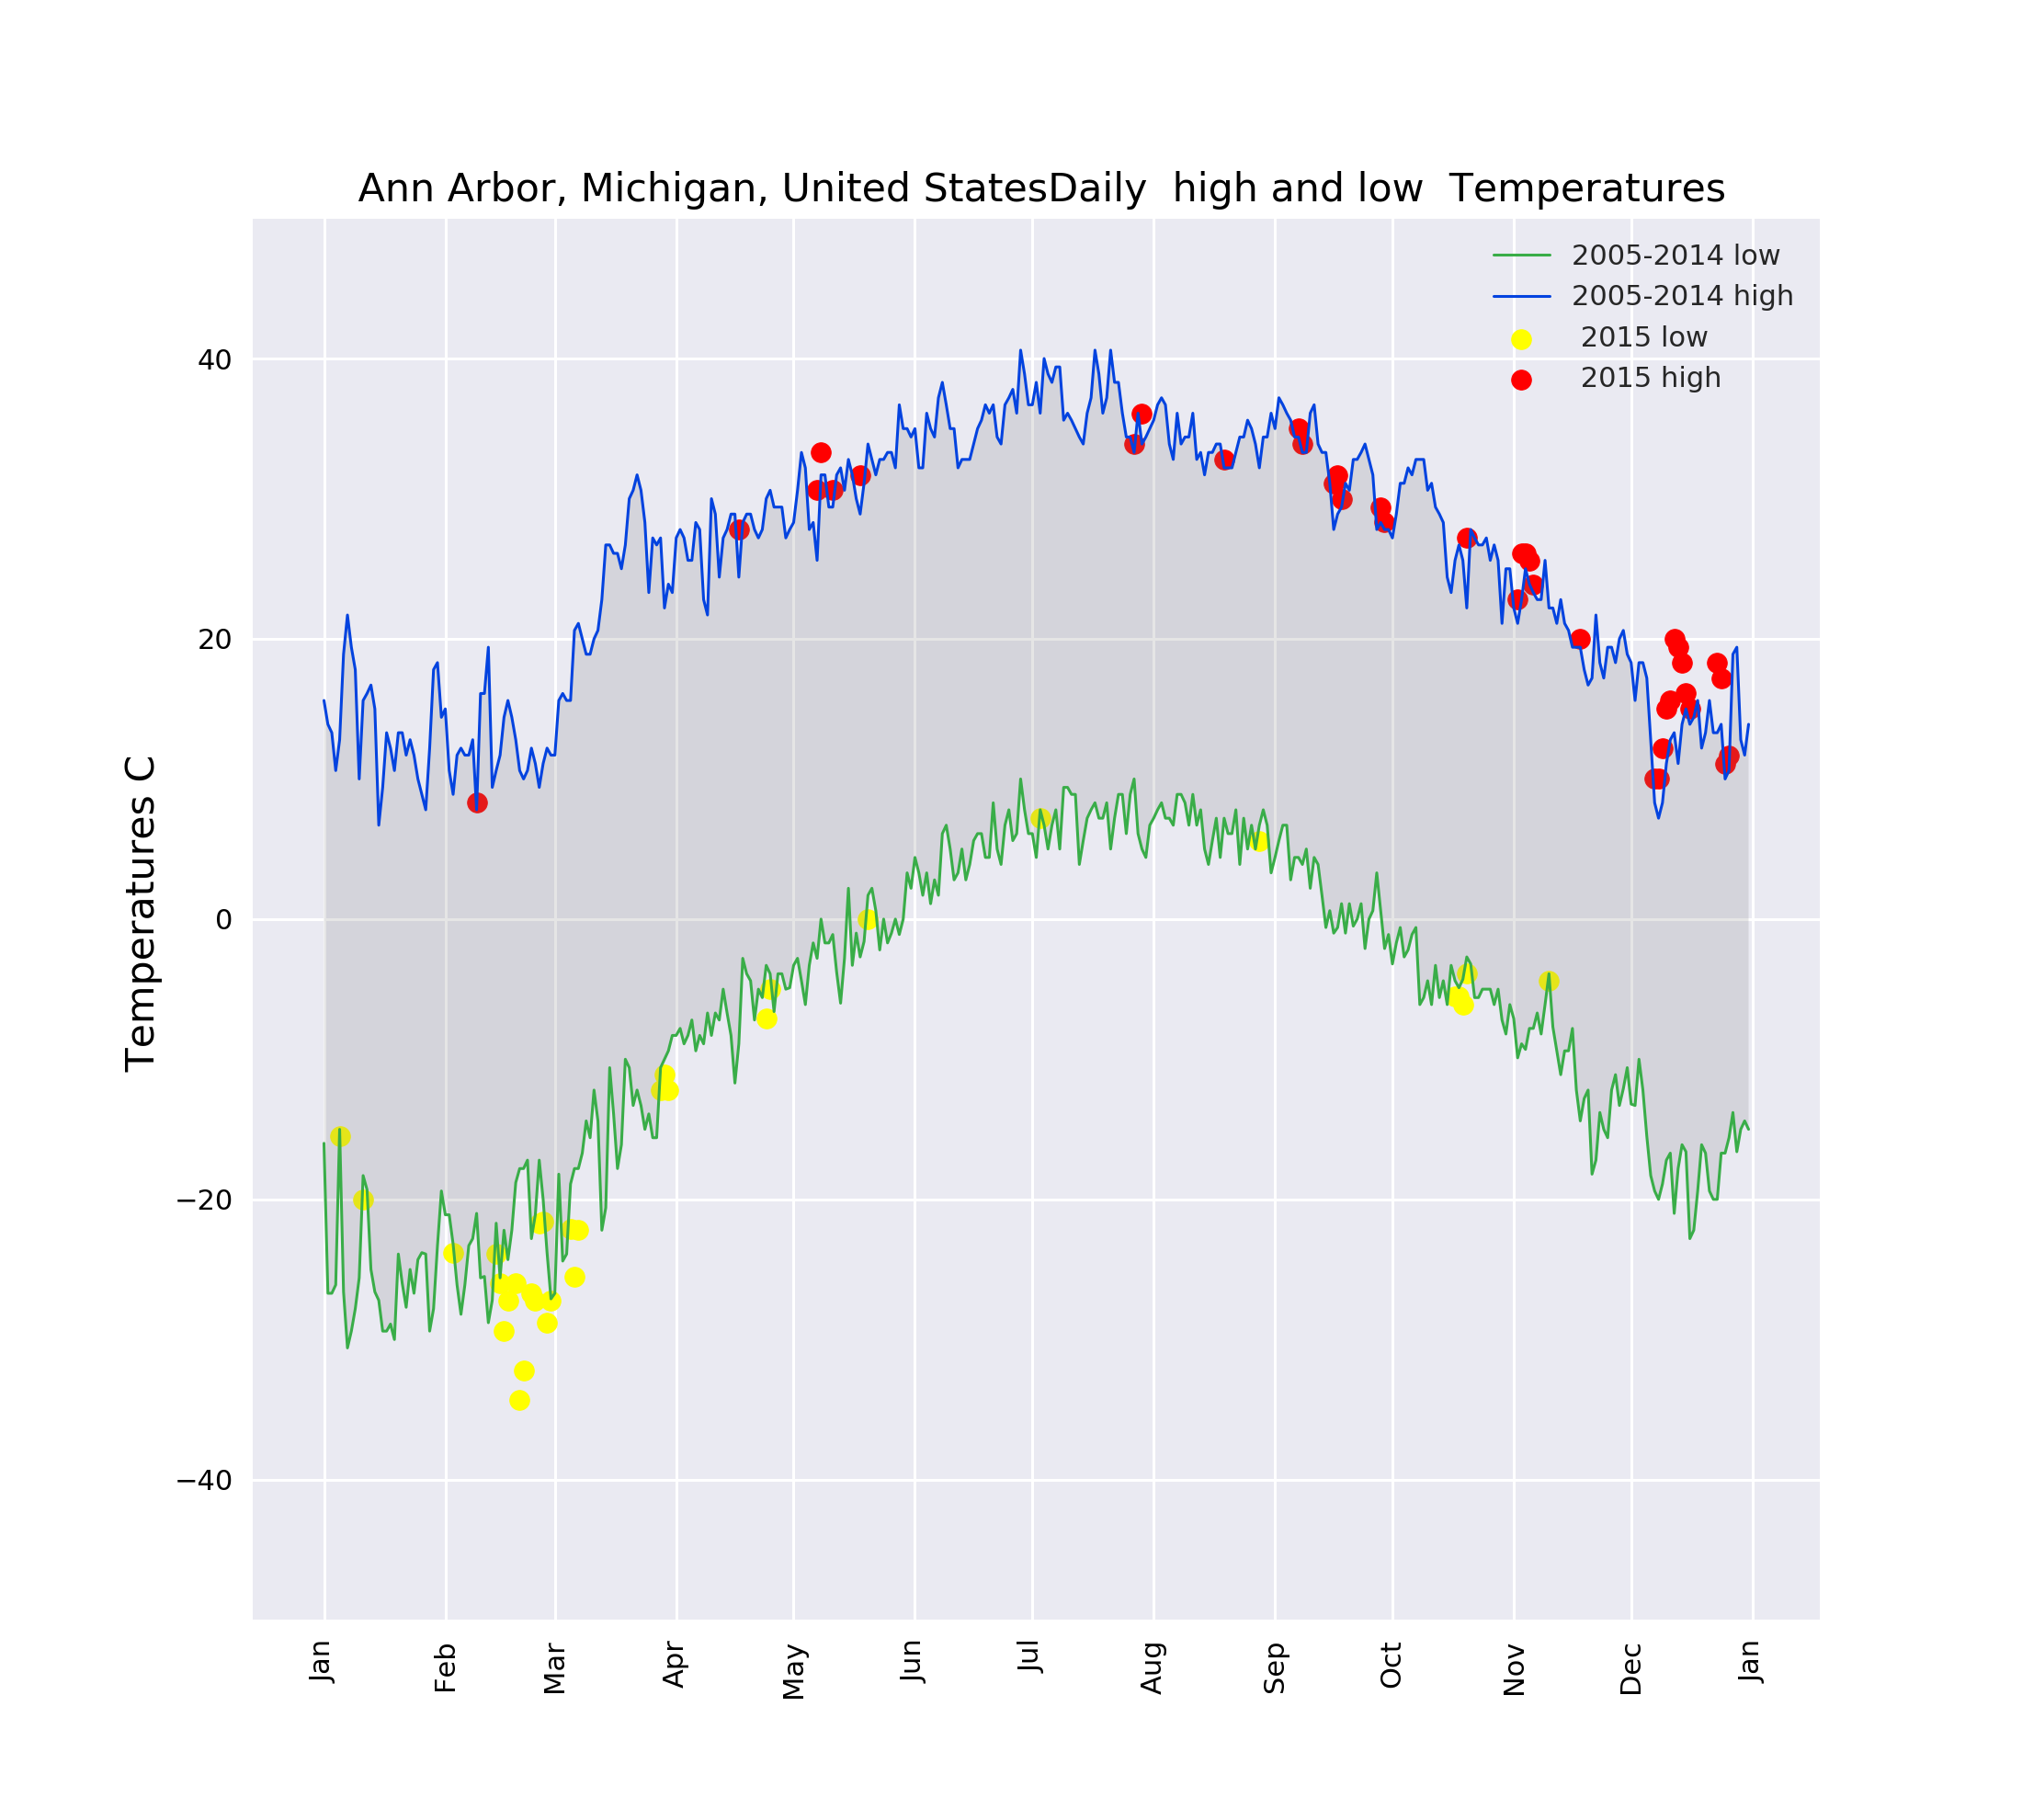

In [18]:

%matplotlib notebook


# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  graph size
plt.figure(figsize=(10, 9))  
#plt.figure()
################Part1 load data in graph ####################

# Plot the record low and high from 2005-2014
plt.plot(df0514['md'], df0514['min'], sns.xkcd_rgb["medium green"], lw=1, label='2005-2014 low')
plt.plot(df0514['md'], df0514['max'], sns.xkcd_rgb["blue"], lw=1, label='2005-2014 high')

# Plot the scatter points of records broken in 2015

plt.scatter(df0515[df0515.ismin==True]['md'], df0515[df0515.ismin==True]['min2015'], color='yellow', marker='o', s=50, label=' 2015 low ')
plt.scatter(df0515[df0515.ismax==True]['md'], df0515[df0515.ismax==True]['max2015'], color='red', marker='o', s=50, label=' 2015 high ')



# fill the area between the record low and highs from 2005-2014
ax = plt.gca()
plt.gca().fill_between(df0514['md'], 
                       df0514['min'], df0514['max'], 
                       facecolor='grey', 
                       alpha=0.2)

 #############part2 set up the frame ##################### 
    
# Remove the plot frame lines. They are unnecessary chartjunk.  
#ax = plt.subplot(111)  
#ax.spines["top"].set_visible(False)  
#ax.spines["right"].set_visible(False)  

# Set date axis format, set dates from float number to month
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
ax.xaxis.set_major_locator(dates.MonthLocator())
loc, labels = plt.xticks()
plt.setp(labels, rotation=90)
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 


#set up y range  
plt.ylim(-50, 50)  
# set up y label    
plt.ylabel(" Temperatures C", fontsize=14,color='black')  
plt.legend(loc='best')
#set title name  and front , color
plt.title(' Ann Arbor, Michigan, United StatesDaily  high and low  Temperatures',fontsize=14, color='black')
# set x,y axis color
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Show the plot
plt.show()

In [117]:
plt.savefig('test2.png', format='png')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
